# Economic Data Analysis from Fred Website

In [1]:
!pip install fredapi > /dev/null

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

fred_key = '882c74264b46291bbf74c610f67d2fb2'

### 1. Create The Fred Object

In [2]:
fred = Fred(api_key = fred_key)

### 2. Search for economic data!

In [3]:
sp_search = fred.search('S&P', order_by = 'popularity')

In [4]:
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2024-02-29,2024-02-29,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2024-02-27,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2024-02-27 21:27:02-06:00,92,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2024-02-29,2024-02-29,S&P CoreLogic Case-Shiller U.S. National Home ...,1987-01-01,2023-12-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2024-02-27 08:14:02-06:00,88,"For more information regarding the index, plea..."
SP500,SP500,2024-02-29,2024-02-29,S&P 500,2014-03-03,2024-02-28,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2024-02-28 19:10:57-06:00,83,The observations for the S&P 500 represent the...
MEHOINUSA672N,MEHOINUSA672N,2024-02-29,2024-02-29,Real Median Household Income in the United States,1984-01-01,2022-01-01,Annual,A,2022 CPI-U-RS Adjusted Dollars,2022 CPI-U-RS Adjusted $,Not Seasonally Adjusted,NSA,2023-09-12 13:48:02-05:00,83,Household data are collected as of March. As ...
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2024-02-29,2024-02-29,ICE BofA US High Yield Index Effective Yield,1996-12-31,2024-02-27,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2024-02-27 21:27:06-06:00,82,This data represents the effective yield of th...


### 3. Pull Raw Data & Plot

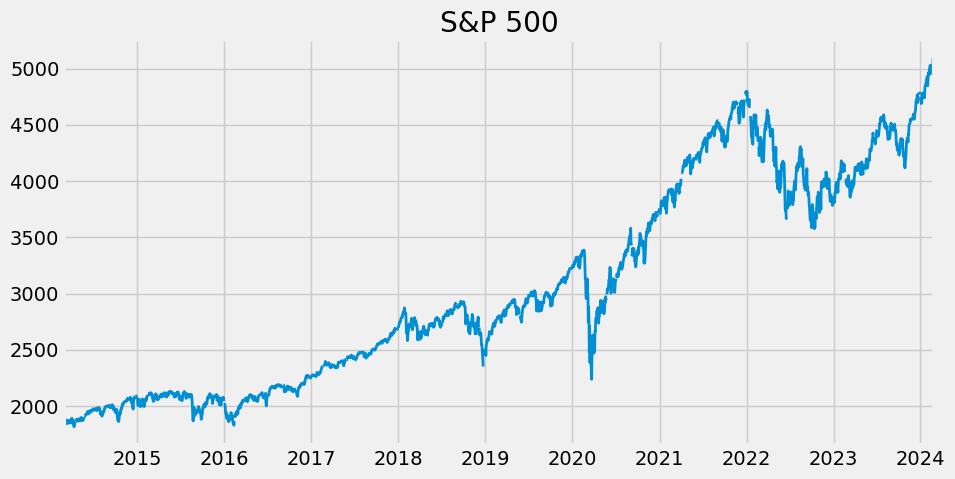

In [5]:
sp500 = fred.get_series(series_id='SP500')
sp500.plot(figsize = (10,5), title = 'S&P 500', lw = 2)
plt.show()

____________

### 4. Pull and Join Multiple Data Series

In [6]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))

In [7]:
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [8]:
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate in')]

In [9]:
all_results = []

for myid in unemp_df.index:
    try:
        results = fred.get_series(myid)
        results = results.to_frame(name=myid)
        all_results.append(results)
        time.sleep(0.1)  # Don't request too fast and risk getting blocked
    except Exception as e:
        print(f"Error fetching data for {myid}: {e}")

uemp_results = pd.concat(all_results, axis=1)


Error fetching data for CAUR: <urlopen error [Errno 60] Operation timed out>
Error fetching data for NYUR: <urlopen error [Errno 60] Operation timed out>
Error fetching data for OHUR: <urlopen error [Errno 60] Operation timed out>
Error fetching data for ALUR: <urlopen error [Errno 60] Operation timed out>
Error fetching data for ILUR: <urlopen error [Errno 60] Operation timed out>
Error fetching data for GAUR: <urlopen error [Errno 60] Operation timed out>
Error fetching data for AZUR: <urlopen error [Errno 60] Operation timed out>
Error fetching data for DEUR: <urlopen error [Errno 60] Operation timed out>
Error fetching data for CWSTUR: <urlopen error [Errno 60] Operation timed out>


In [48]:
uemp_states = uemp_results.drop('LASMT391746000000003', axis = 1).dropna(axis = 1)
uemp_states = uemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

In [49]:
px.line(uemp_states)

### Pull April 2020 Unemployment Rate Per State

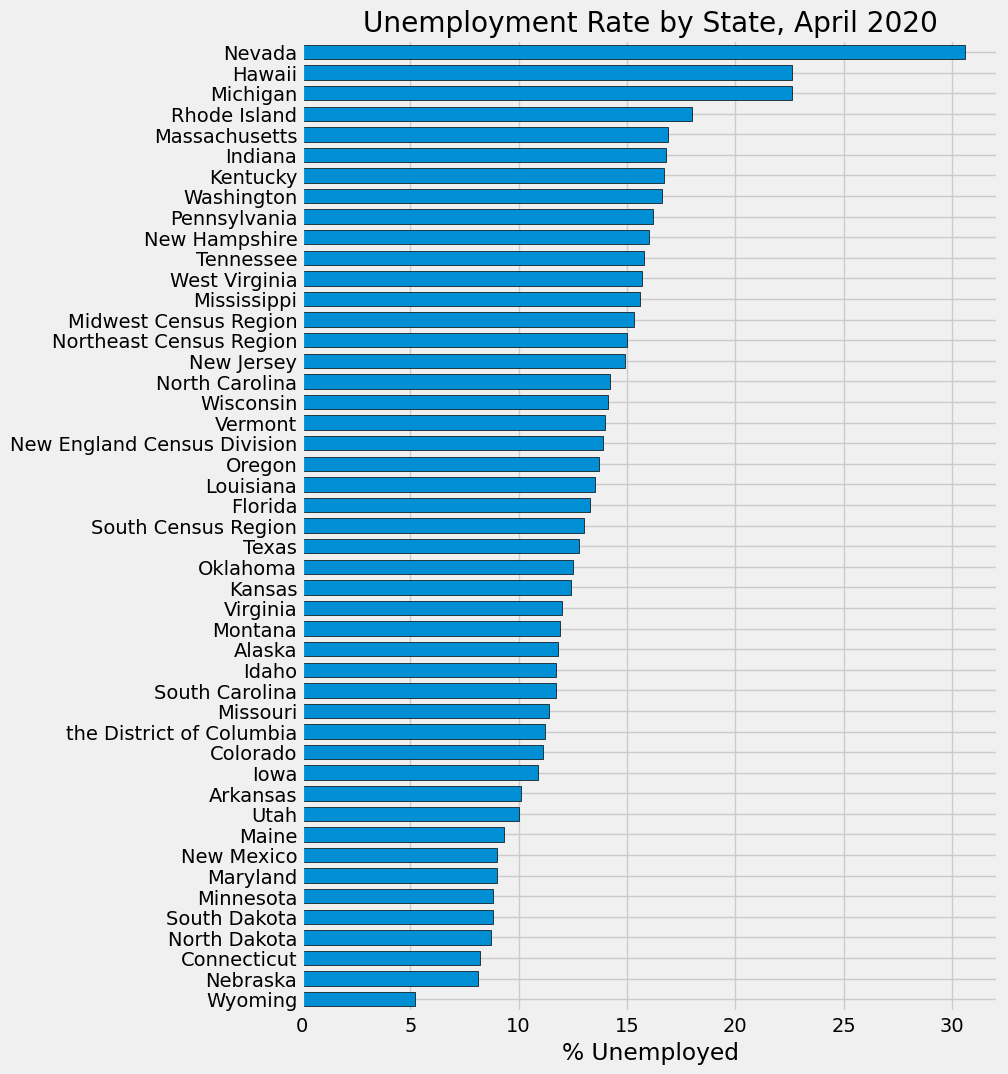

In [64]:
ax = uemp_states.loc[uemp_states.index == '2020-04-01'].T \
    .sort_values('2020-04-01') \
    .plot(kind='barh', figsize = (8, 12), width = 0.7, edgecolor='black',
          title='Unemployment Rate by State, April 2020')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.show()

_____

## Pull Participation Rate

In [65]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [70]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    try:
        results = fred.get_series(myid)
        results = results.to_frame(name=myid)
        all_results.append(results)
        time.sleep(0.1)  # Don't request too fast and risk getting blocked
    except Exception as e:
        print(f"Error fetching data for {myid}: {e}")

part_states = pd.concat(all_results, axis=1)


Error fetching data for CIVPART: <urlopen error [Errno 60] Operation timed out>
Error fetching data for LNS11300060: <urlopen error [Errno 60] Operation timed out>
Error fetching data for LNS11300006: <urlopen error [Errno 60] Operation timed out>
Error fetching data for LNS11300036: <urlopen error [Errno 60] Operation timed out>
Error fetching data for LNS11327662: <urlopen error [Errno 60] Operation timed out>
Error fetching data for LBSSA12: <urlopen error [Errno 60] Operation timed out>
Error fetching data for LBSSA39: <urlopen error [Errno 60] Operation timed out>
Error fetching data for LBSSA25: <urlopen error [Errno 60] Operation timed out>
Error fetching data for LNS11327659: <urlopen error [Errno 60] Operation timed out>
Error fetching data for LBSSA23: <urlopen error [Errno 60] Operation timed out>
Error fetching data for LBSSA37: <urlopen error [Errno 60] Operation timed out>
Error fetching data for LBSSA45: <urlopen error [Errno 60] Operation timed out>
Error fetching data 

In [91]:
[part_id_to_state[c] for c in part_states.columns]a

['Labor Force Participation Rate - Women',
 'Labor Force Participation Rate - Men',
 'Labor Force Participation Rate - 55 Yrs. & over',
 'Labor Force Participation Rate - 16-19 Yrs.',
 'Activity Rate: Aged 25-54: Males for United States',
 'Activity Rate: Aged 25-54: Females for United States',
 'California',
 'Labor Force Participation Rate - 20 Yrs. & over, White Men',
 'Labor Force Participation Rate - 20 Yrs. & over, Black or African American Men',
 'Alabama',
 'Labor Force Participation Rate - White',
 'Labor Force Participation Rate - High School Graduates, No College, 25 Yrs. & over',
 'New York',
 'Labor Force Participation Rate - 20 Yrs. & over, White Women',
 'Michigan',
 'Mississippi',
 'Labor Force Participation Rate - Hispanic or Latino',
 'Labor Force Participation Rate - 20 Yrs. & over, Black or African American Women',
 'Texas',
 'Kentucky',
 'Wisconsin',
 'Pennsylvania',
 'Minnesota',
 'Maryland',
 'West Virginia',
 'Tennessee',
 'Illinois',
 'Georgia',
 'Louisiana',
 

<Axes: title={'center': 'Unemployment Rate by State, April 2020'}, xlabel='% Unemployed'>